In [101]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from tabulate import tabulate
get_ipython().run_line_magic('matplotlib', 'inline')
from IPython.display import display, HTML

In [102]:
df1 = pd.read_csv('/home/hanping/remote file/MFB/dataset/processed/text_grouped.csv')

In [103]:
df2 = pd.read_csv('/home/hanping/remote file/MFB/dataset/processed/btc_grouped.csv')

In [104]:
df1['date'] = pd.to_datetime(df1['date'])
df1.set_index('date', inplace=True)

df2['date'] = pd.to_datetime(df2['date'])
df2.set_index('date', inplace=True)

In [105]:
# merge the two dataframes
df_merged = pd.merge(df1, df2, on='date', how='inner')

df_merged = df_merged.sort_values('date')
df = df_merged

target_col = 'Close'
df.head()

,compound,Close,Stochastic,ADI,EMA,MACD,RSI,OBV,ATR
date,,,,,,,,,
2021-01-01 01:00:00,0.2263,29409.99,96.295679,1229681.093,28947.88120,164.922849,62.207462,540756.7353,388.070365
2021-01-01 02:00:00,0.0000,29194.65,83.003086,1228327.545,28980.78371,170.457230,57.314228,538372.5037,385.010339
2021-01-01 03:00:00,0.0000,29278.40,85.898804,1228595.460,29020.46588,179.531664,58.675685,539833.8488,373.008172
2021-01-01 04:00:00,0.0000,29220.31,78.456428,1228685.879,29047.11176,179.961357,57.310301,537795.8020,372.479017
2021-01-01 05:00:00,0.0000,29187.01,75.583261,1229217.093,29065.76486,175.590760,56.498663,536325.8457,356.671230


In [106]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [107]:
train, test = train_test_split(df2, test_size=0.2)


In [108]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=1):
    fig, ax = plt.subplots(1, figsize=(12,5))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [BTC]', fontsize=16)
    ax.set_xlabel('Time', fontsize=16)
    plt.rcParams['axes.labelcolor'] = 'k'
    plt.rcParams['xtick.color'] = 'k'
    plt.rcParams['ytick.color'] = 'k'
    ax.tick_params(labelsize=11)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=11);


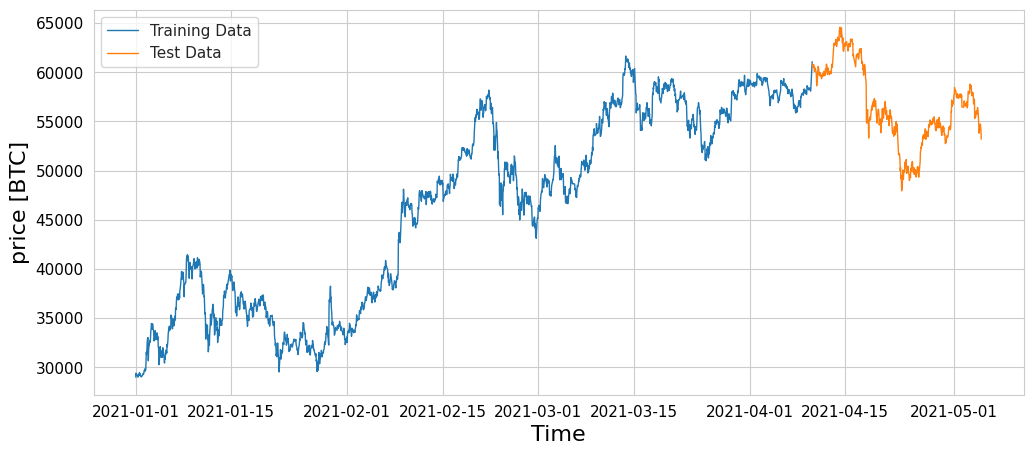

In [109]:
line_plot(train[target_col], test[target_col], 'Training Data', 'Test Data', title='')

In [110]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (df.max() - df.min())

In [111]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)


In [112]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test


Building LSTM Model

In [113]:
def build_lstm_model(input_data, output_size, neurons=100,activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1],input_data.shape[2])))
    model.add(Dropout(dropout))
    
    
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model


In [114]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 256
epochs = 50
batch_size = 16
loss = 'mse'
dropout = 0.2
optimizer = 'adam'


In [115]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    df2, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [116]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
141/141 [==============================] - 3s 13ms/step - loss: 0.0098 - val_loss: 0.0049
Epoch 2/50
141/141 [==============================] - 1s 9ms/step - loss: 0.0057 - val_loss: 0.0012
Epoch 3/50
141/141 [==============================] - 1s 9ms/step - loss: 0.0037 - val_loss: 5.3824e-04
Epoch 4/50
141/141 [==============================] - 1s 9ms/step - loss: 0.0022 - val_loss: 2.5077e-04
Epoch 5/50
141/141 [==============================] - 1s 9ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 6/50
141/141 [==============================] - 1s 9ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 7/50
141/141 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 4.5476e-04
Epoch 8/50
141/141 [==============================] - 1s 9ms/step - loss: 0.0018 - val_loss: 6.2021e-04
Epoch 9/50
141/141 [==============================] - 1s 9ms/step - loss: 0.0011 - val_loss: 5.6884e-04
Epoch 10/50
141/141 [==============================] - 1s 9ms/step - loss: 0.00

In [117]:
path='/home/hanping/remote file/MFB/prediction_result/'

In [118]:
# Save the model
model.save(path+'LSTM_model.h5')

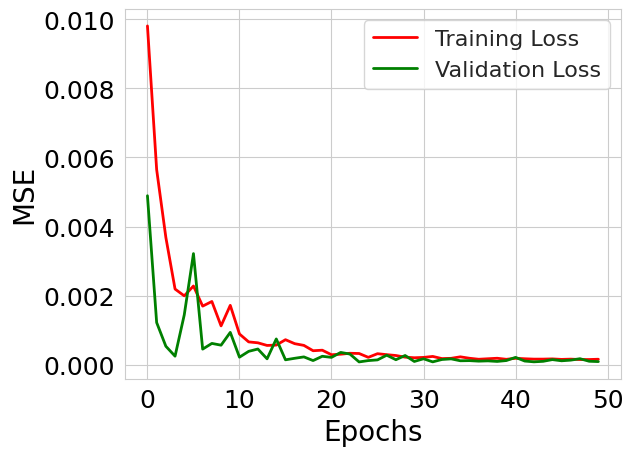

In [119]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Training loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
#plt.title('LSTM Model')
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('MSE',fontsize=20)
plt.tick_params(labelsize=18)
plt.legend(('Training Loss', 'Validation Loss'),fontsize=16)
plt.show()


In [120]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(y_test, preds)

18/18 [==============================] - 1s 5ms/step


0.006623782031826068

In [121]:
from sklearn.metrics import mean_squared_error
MSE=mean_squared_error(preds, y_test)
MSE

9.415820741205463e-05

In [122]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.7021379922171569

In [123]:
#RMSE
import math
rmse=math.sqrt(MSE)
rmse

0.009703515209039178

In [124]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_test, preds)


3.130258965660528

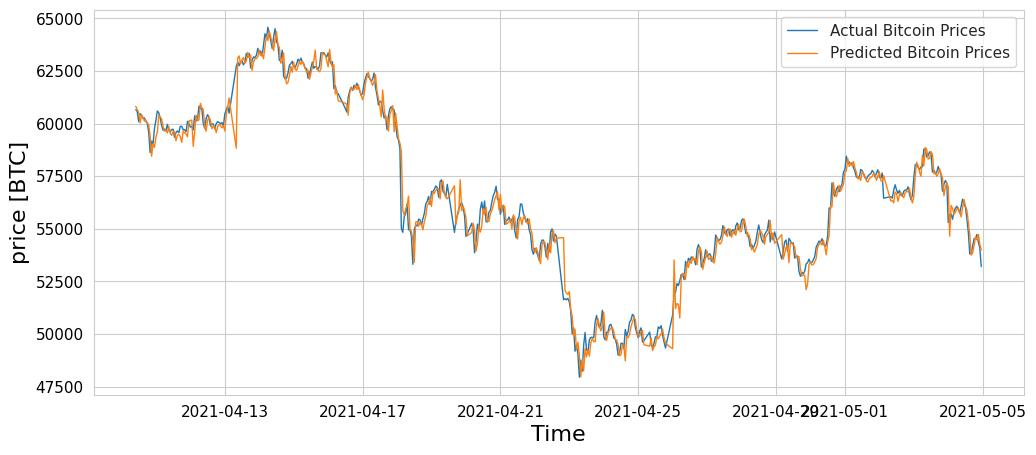

In [125]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'Actual Bitcoin Prices', 'Predicted Bitcoin Prices', lw=1)

In [126]:
model1_preds=preds

# GRU

In [127]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, Bidirectional, GRU
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
get_ipython().run_line_magic('matplotlib', 'inline')

In [128]:
#PRICE NORMALISATION

In [129]:
def build_gru_model(input_data, output_size, neurons=100,activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(GRU(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    
    
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model


In [130]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
gru_neurons = 256
epochs = 50
batch_size = 16
loss = 'mse'
dropout = 0.2
optimizer = 'adam'


In [131]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    df2, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [132]:
model = build_gru_model(
    X_train, output_size=1, neurons=gru_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
141/141 [==============================] - 4s 13ms/step - loss: 0.0177 - val_loss: 0.0080
Epoch 2/50
141/141 [==============================] - 1s 9ms/step - loss: 0.0176 - val_loss: 0.0109
Epoch 3/50
141/141 [==============================] - 1s 9ms/step - loss: 0.0113 - val_loss: 0.0043
Epoch 4/50
141/141 [==============================] - 1s 9ms/step - loss: 0.0100 - val_loss: 0.0066
Epoch 5/50
141/141 [==============================] - 1s 10ms/step - loss: 0.0068 - val_loss: 0.0042
Epoch 6/50
141/141 [==============================] - 1s 10ms/step - loss: 0.0065 - val_loss: 0.0021
Epoch 7/50
141/141 [==============================] - 1s 9ms/step - loss: 0.0042 - val_loss: 0.0031
Epoch 8/50
141/141 [==============================] - 1s 9ms/step - loss: 0.0060 - val_loss: 0.0037
Epoch 9/50
141/141 [==============================] - 1s 9ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 10/50
141/141 [==============================] - 1s 9ms/step - loss: 0.0038 - val_loss: 0.0

In [133]:
# Save the model
model.save(path+'GRU_model.h5')

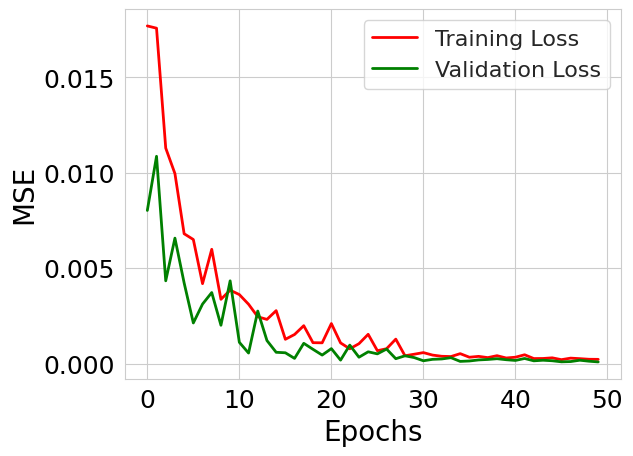

In [134]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Training loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
#plt.title('LSTM Model')
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('MSE',fontsize=20)
plt.tick_params(labelsize=18)
plt.legend(('Training Loss', 'Validation Loss'),fontsize=16)
plt.show()

In [135]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(y_test, preds)

18/18 [==============================] - 0s 5ms/step


0.006385359601935028

In [136]:
from sklearn.metrics import mean_squared_error
MSE=mean_squared_error(preds, y_test)
MSE


8.29000373383995e-05

In [137]:
#RMSE
import math
rmse=math.sqrt(MSE)
rmse


0.009104945762518276

In [138]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2


0.7377523187242938

In [139]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_test, preds)

2.9092479399455424

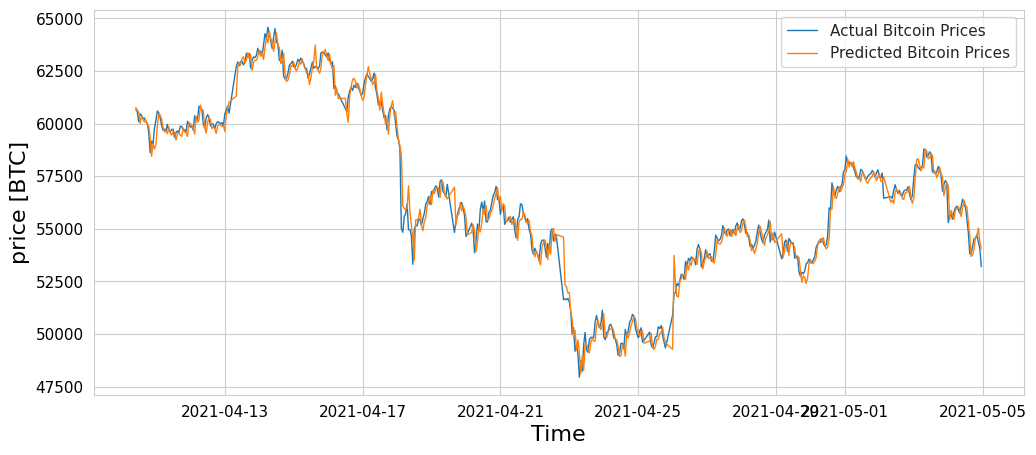

In [140]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'Actual Bitcoin Prices', 'Predicted Bitcoin Prices', lw=1)

In [141]:
model2_preds=preds

# BiLSTM

In [142]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, Bidirectional, GRU
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
get_ipython().run_line_magic('matplotlib', 'inline')


In [143]:
def build_Bilstm_model(input_data, output_size, neurons=100,activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(Bidirectional(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2]))))
    model.add(Dropout(dropout))
    
    
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model


In [144]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 256
epochs = 50
batch_size = 8
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [145]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    df2, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [146]:
model = build_Bilstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
281/281 [==============================] - 6s 11ms/step - loss: 0.0160 - val_loss: 0.0044
Epoch 2/50
281/281 [==============================] - 2s 9ms/step - loss: 0.0051 - val_loss: 0.0010
Epoch 3/50
281/281 [==============================] - 2s 9ms/step - loss: 0.0024 - val_loss: 0.0010
Epoch 4/50
281/281 [==============================] - 3s 9ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 5/50
281/281 [==============================] - 2s 9ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 6/50
281/281 [==============================] - 3s 9ms/step - loss: 0.0017 - val_loss: 3.4967e-04
Epoch 7/50
281/281 [==============================] - 3s 9ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 8/50
281/281 [==============================] - 2s 9ms/step - loss: 0.0010 - val_loss: 2.9711e-04
Epoch 9/50
281/281 [==============================] - 2s 9ms/step - loss: 0.0010 - val_loss: 4.9149e-04
Epoch 10/50
281/281 [==============================] - 3s 9ms/step - loss: 9.8388e-04 -

In [147]:
# Save the model
model.save(path+'BiLSTM_model.h5')

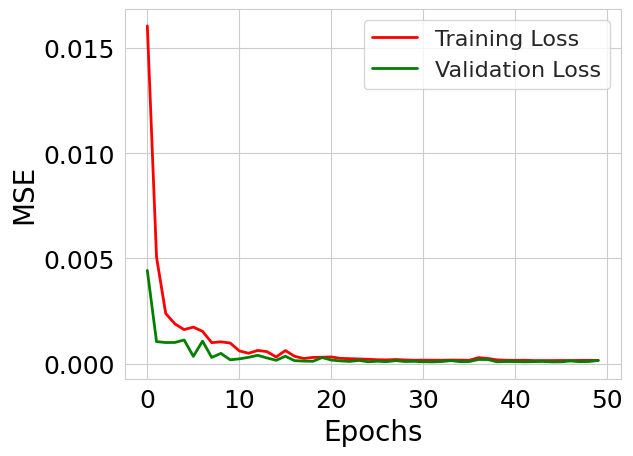

In [148]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Training loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
#plt.title('LSTM Model')
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('MSE',fontsize=20)
plt.tick_params(labelsize=18)
plt.legend(('Training Loss', 'Validation Loss'),fontsize=16)
plt.show()

In [149]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(y_test, preds)

18/18 [==============================] - 1s 5ms/step


0.009224959786984878

In [150]:
from sklearn.metrics import mean_squared_error
MSE=mean_squared_error(preds, y_test)
MSE


0.0001553887348832362

In [151]:
#RMSE
import math
rmse=math.sqrt(MSE)
rmse


0.012465501790270466

In [152]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2


0.5084400836497756

In [153]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_test, preds)

4.82656943598859

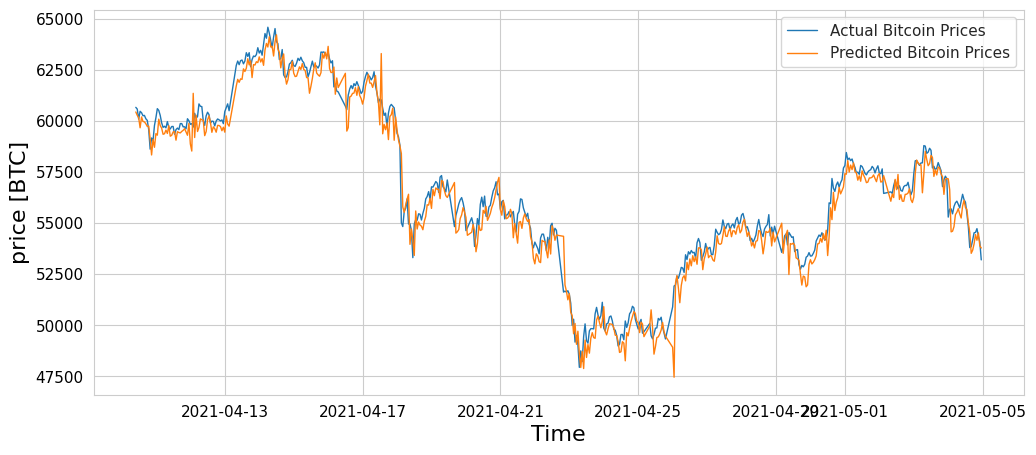

In [154]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'Actual Bitcoin Prices', 'Predicted Bitcoin Prices', lw=1)

In [155]:
model3_preds=preds

# BiGRU

In [156]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, Bidirectional, GRU, BatchNormalization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
get_ipython().run_line_magic('matplotlib', 'inline')

In [157]:
def build_BiGRU_model(input_data, output_size, neurons=100,activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(Bidirectional(GRU(neurons, input_shape=(input_data.shape[1], input_data.shape[2]))))
    model.add(Dropout(dropout))
    
    
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model


In [158]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
BiGRU_neurons = 256
epochs = 50
batch_size = 8
loss = 'mse'
dropout = 0.2
optimizer = 'adam'


In [159]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    df2, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)


In [160]:
model = build_BiGRU_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
281/281 [==============================] - 7s 12ms/step - loss: 0.0297 - val_loss: 0.0051
Epoch 2/50
281/281 [==============================] - 3s 9ms/step - loss: 0.0123 - val_loss: 0.0094
Epoch 3/50
281/281 [==============================] - 3s 9ms/step - loss: 0.0089 - val_loss: 0.0011
Epoch 4/50
281/281 [==============================] - 3s 10ms/step - loss: 0.0077 - val_loss: 0.0058
Epoch 5/50
281/281 [==============================] - 3s 9ms/step - loss: 0.0057 - val_loss: 0.0022
Epoch 6/50
281/281 [==============================] - 3s 9ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 7/50
281/281 [==============================] - 3s 9ms/step - loss: 0.0057 - val_loss: 0.0013
Epoch 8/50
281/281 [==============================] - 3s 9ms/step - loss: 0.0026 - val_loss: 0.0035
Epoch 9/50
281/281 [==============================] - 3s 9ms/step - loss: 0.0020 - val_loss: 7.4918e-04
Epoch 10/50
281/281 [==============================] - 2s 9ms/step - loss: 0.0026 - val_loss: 

In [161]:
# Save the model
model.save(path+'BiGRU_model.h5')

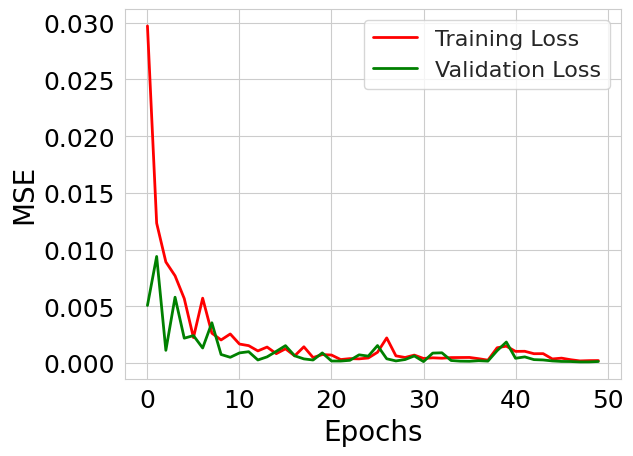

In [162]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Training loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
#plt.title('LSTM Model')
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('MSE',fontsize=20)
plt.tick_params(labelsize=18)
plt.legend(('Training Loss', 'Validation Loss'),fontsize=16)
plt.show()

In [163]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(y_test, preds)

18/18 [==============================] - 1s 5ms/step


0.007845147967733043

In [164]:
from sklearn.metrics import mean_squared_error
MSE=mean_squared_error(preds, y_test)
MSE

0.0001291838390410618

In [165]:
#RMSE
import math
rmse=math.sqrt(MSE)
rmse

0.011365906872795581

In [166]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2


0.5913371895295871

In [167]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_test, preds)

2.976428346211309

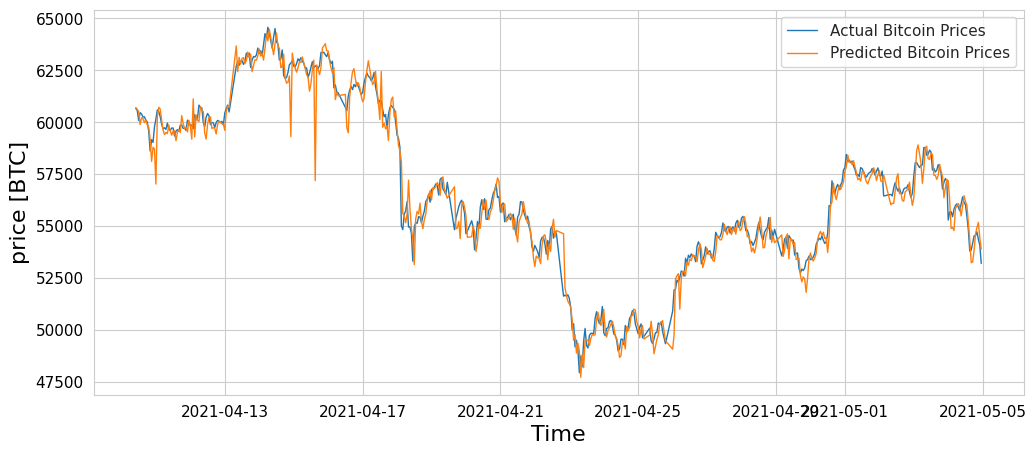

In [168]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'Actual Bitcoin Prices', 'Predicted Bitcoin Prices', lw=1)

In [169]:
model4_preds=preds

# Hybrid Model



In [170]:
import json
import requests
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, Bidirectional, GRU, BatchNormalization
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
get_ipython().run_line_magic('matplotlib', 'inline')

In [171]:
print(tf.__version__)

2.11.0


In [172]:
def build_hybrid_model(input_data, output_size, neurons=100,activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    
    
    model = Sequential()
    model.add(Bidirectional(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2]), return_sequences=True)))
    model.add(Dropout(dropout))
    model.add(Bidirectional(GRU(neurons, return_sequences=False)))
    model.add(Dropout(0.2))
    
    
    model.add(Dense(units=output_size, activation=activ_func))


    model.compile(loss=loss, optimizer=optimizer)
    return model


In [173]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
hybrid_neurons = 256
epochs = 50
batch_size = 8
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [174]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    df2, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [175]:
model = build_hybrid_model(
    X_train, output_size=1, neurons=hybrid_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
281/281 [==============================] - 13s 24ms/step - loss: 0.0288 - val_loss: 0.0139
Epoch 2/50
281/281 [==============================] - 5s 19ms/step - loss: 0.0105 - val_loss: 0.0016
Epoch 3/50
281/281 [==============================] - 5s 19ms/step - loss: 0.0017 - val_loss: 0.0037
Epoch 4/50
281/281 [==============================] - 5s 19ms/step - loss: 0.0025 - val_loss: 9.5022e-04
Epoch 5/50
281/281 [==============================] - 5s 19ms/step - loss: 0.0017 - val_loss: 7.7771e-04
Epoch 6/50
281/281 [==============================] - 5s 19ms/step - loss: 8.4810e-04 - val_loss: 7.0998e-04
Epoch 7/50
281/281 [==============================] - 5s 19ms/step - loss: 0.0017 - val_loss: 9.7823e-04
Epoch 8/50
281/281 [==============================] - 5s 19ms/step - loss: 0.0015 - val_loss: 8.1999e-04
Epoch 9/50
281/281 [==============================] - 5s 19ms/step - loss: 6.6666e-04 - val_loss: 3.1912e-04
Epoch 10/50
281/281 [==============================] - 5s 

In [176]:
# Save the model
model.save(path+'hybrid_model.h5')

In [177]:
import pickle

# Assume that 'model' is the trained model
with open(path+'hybrid_model.pkl', 'wb') as f:
    pickle.dump(model, f)


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirectional_1
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
...metrics
......mean
.........vars
............0
....

In [178]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 5, 512)           542720    
 nal)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 5, 512)            0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 512)              1182720   
 nal)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 513       
                                                                 
Total params: 1,725,953
Trainable params: 1,725,953
No

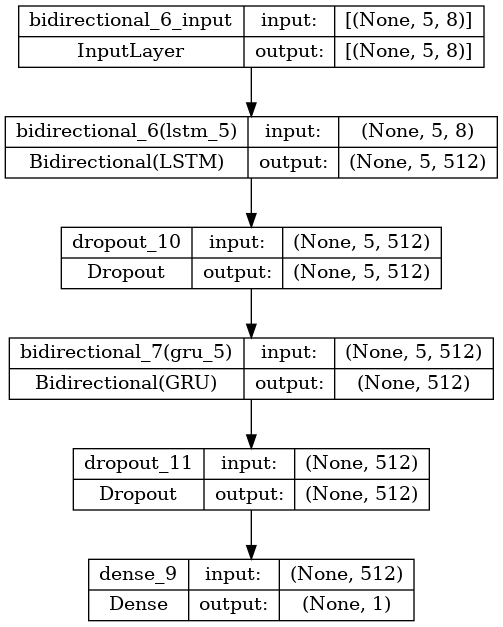

In [179]:
plot_model(model, to_file=path+'hybrid_model.png', show_shapes=True)

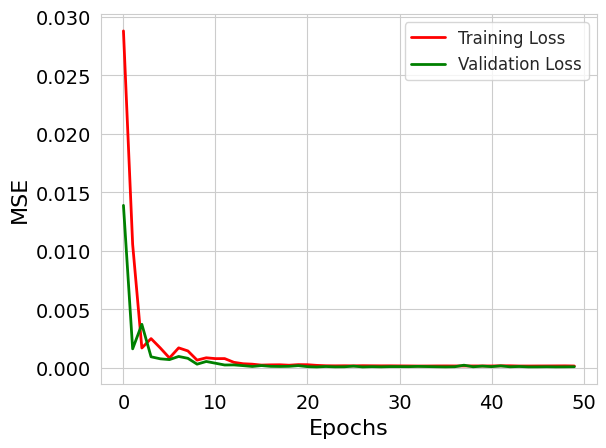

In [180]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Training loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
#plt.title('LSTM Model')
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('MSE',fontsize=16)
plt.tick_params(labelsize=14)
plt.legend(('Training Loss', 'Validation Loss'),fontsize=12)
plt.show()

In [181]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(y_test, preds)

18/18 [==============================] - 1s 10ms/step


0.007029184306663354

In [182]:
from sklearn.metrics import mean_squared_error
MSE=mean_squared_error(preds, y_test)
MSE


0.00010141054274482145

In [183]:
#RMSE
import math
rmse=math.sqrt(MSE)
rmse

0.010070280172111472

In [184]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.6791958056281647

In [185]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_test, preds)


3.838033386721048

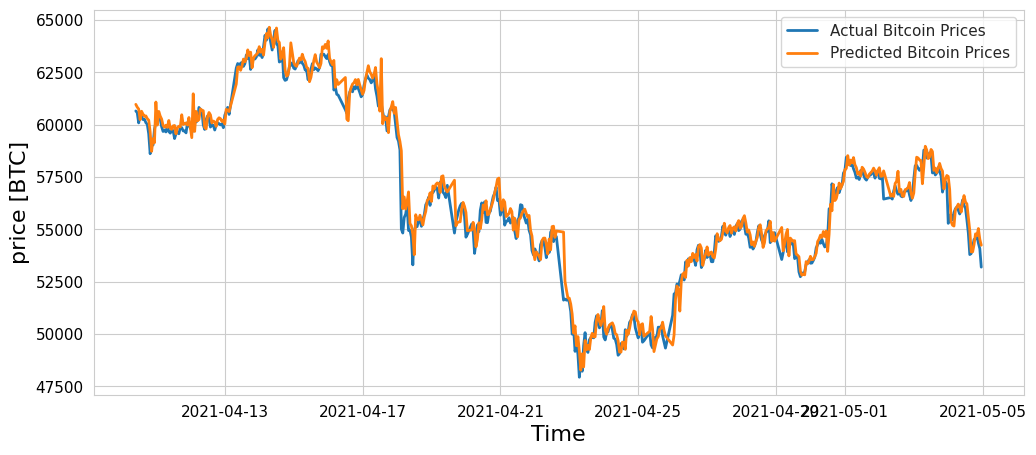

In [186]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'Actual Bitcoin Prices', 'Predicted Bitcoin Prices', lw=2)

In [187]:
model5_preds=preds

In [188]:
def line_plot2(line1, line2, line3, line4, line5, line6, label1=None, label2=None, label3=None, label4=None, label5=None, label6=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(15, 6))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.plot(line3, label=label3, linewidth=lw)
    ax.plot(line4, label=label4, linewidth=lw)
    ax.plot(line5, label=label5, linewidth=lw)
    ax.plot(line6, label=label6, linewidth=lw)
    ax.set_ylabel('price [BTC]', fontsize=18)
    ax.set_xlabel('Time', fontsize=18)
    ax.tick_params(labelsize=11)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=11)

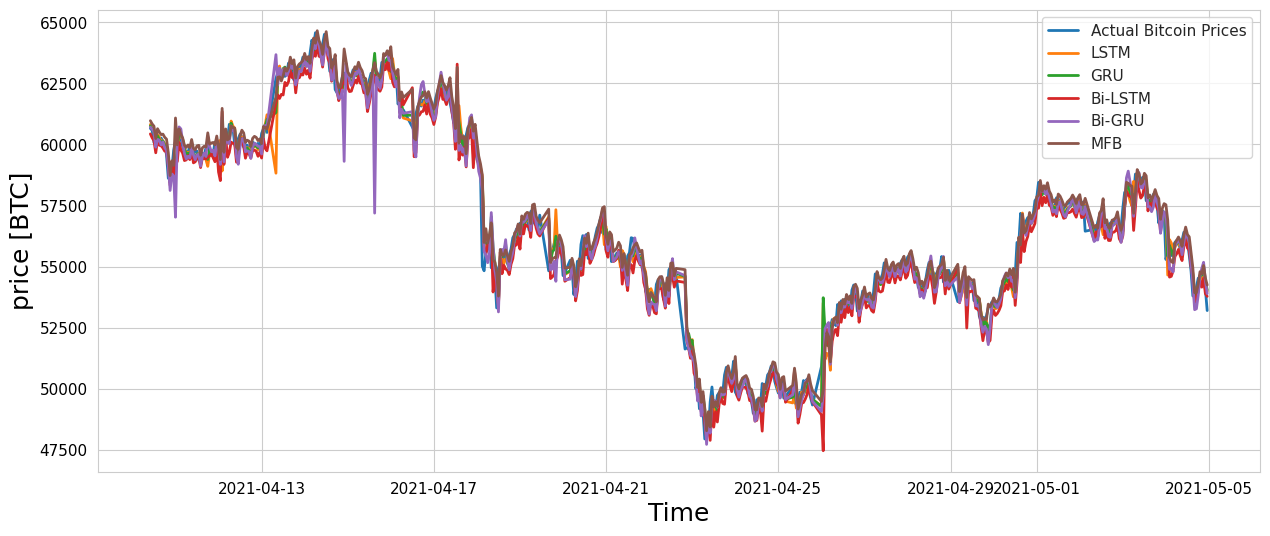

In [189]:
targets = test[target_col][window_len:]
line_plot2(targets, model1_preds, model2_preds, model3_preds, model4_preds, model5_preds, 'Actual Bitcoin Prices', 'LSTM', 'GRU', 'Bi-LSTM', 'Bi-GRU', 'MFB',lw=2)

71/71 [==============================] - 1s 9ms/step


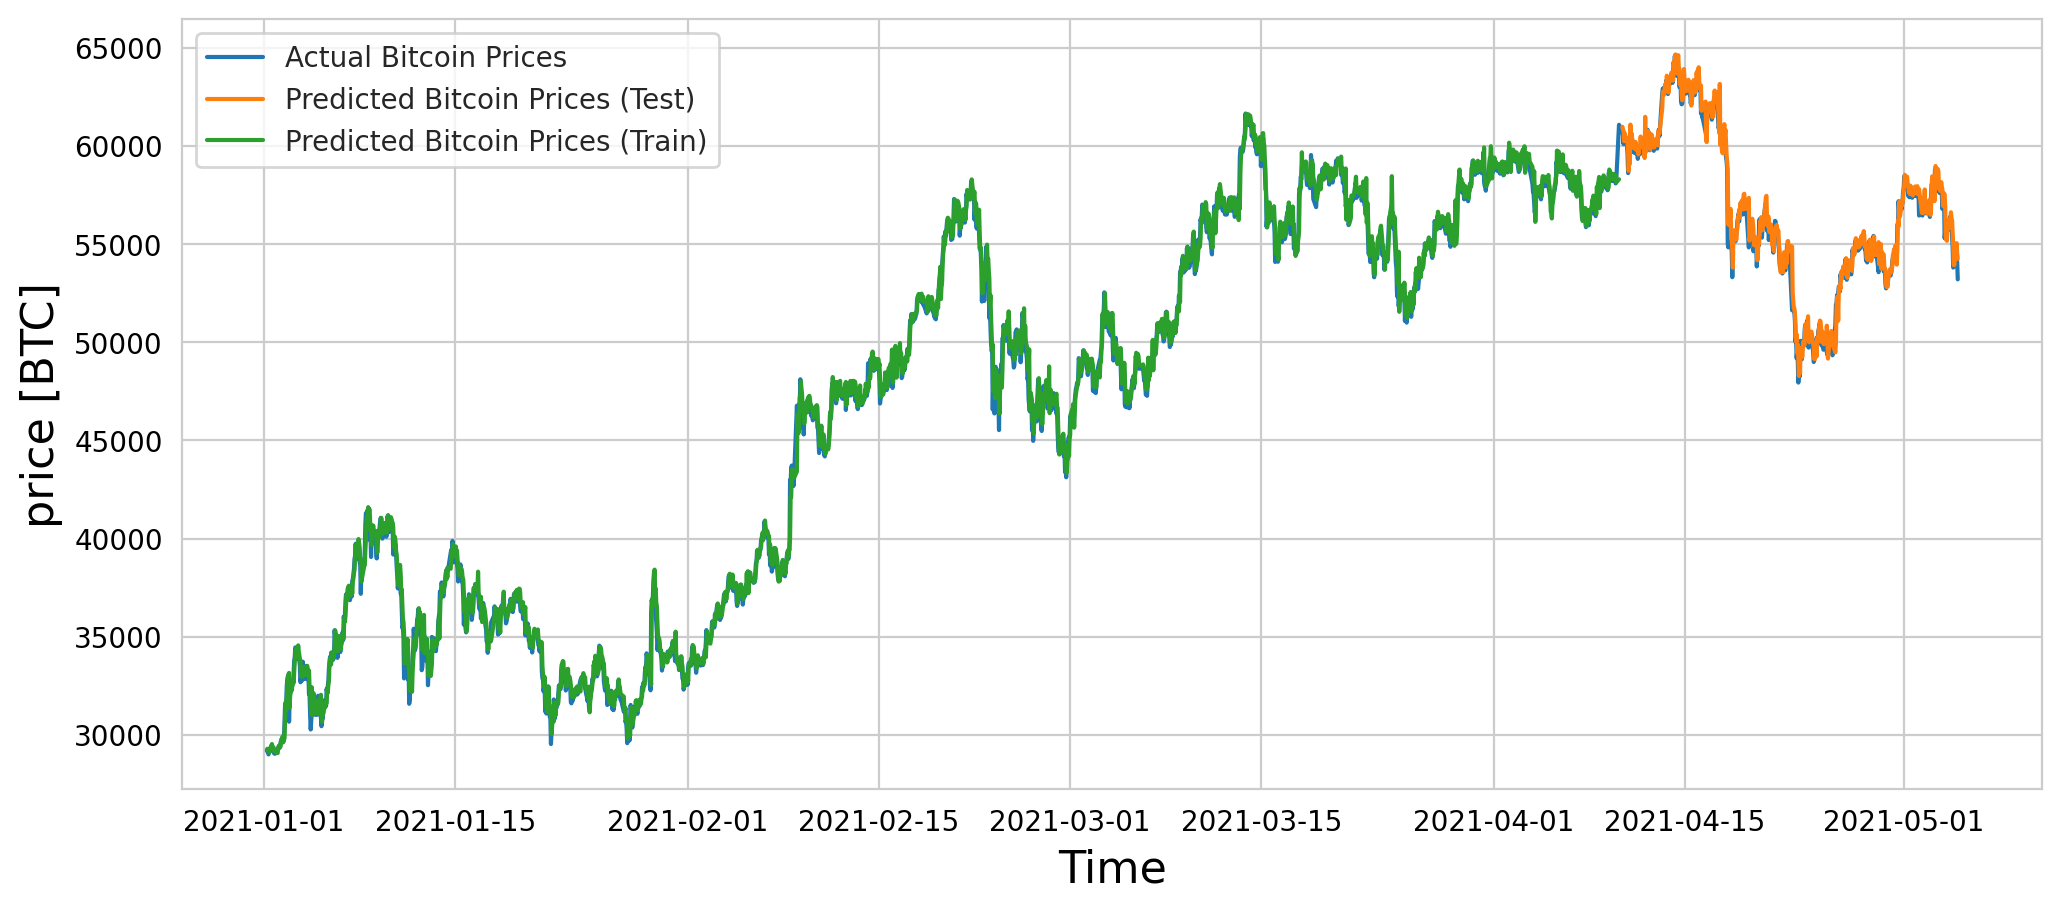

In [190]:
targets = pd.concat([train[target_col][window_len:], test[target_col][window_len:]], axis=0)
# 计算训练集的预测结果
train_preds = model.predict(X_train).squeeze()
# 将预测结果转换为pandas.Series类型，并使用targets的索引和训练集的输出进行归一化还原
train_preds = pd.Series(index=targets.index[:len(train_preds)], data=train_preds.flatten())
train_preds = train[target_col].values[:-window_len] * (train_preds + 1)

# 绘制图形
plt.figure(figsize=(12, 5),dpi=200)  # 设置图形的大小
plt.plot(targets, label='Actual Bitcoin Prices')  # 绘制实际的比特币价格，设置标签
plt.plot(preds, label='Predicted Bitcoin Prices (Test)')  # 绘制测试集的预测结果，设置标签
plt.plot(train_preds,label='Predicted Bitcoin Prices (Train)')  # 绘制训练集的预测结果，设置标签

plt.rcParams['axes.labelcolor'] = 'k'
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'
plt.tick_params(labelsize=10)
plt.legend(loc='best', fontsize=11);
plt.xlabel('Time', fontsize=16)  # 设置x轴的标签
plt.ylabel('price [BTC]', fontsize=16)  # 设置y轴的标签
plt.legend()  # 显示图例

plt.show()  # 显示图形
